# Cycle determination (MSAP4-06)

This notebook provides the test cases described in the MSAP4-06 submodule documentation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import star_privateer as sp

In [3]:
sp.__version__

'1.1.2'

## Preprocessing

In order to demonstrate the ability of MSAP4-06, we choose KIC~3733735, as its observing time/rotation period ratio is important and will allow us to perform meaningful computation on the $S_\mathrm{ph}$ time series. We then start by computing this ACF time series, which is normally an IDP input provided by MSAP4-03. We consider the 2.57 days rotation period from [Santos et al. (2021)](https://ui.adsabs.harvard.edu/abs/2021ApJS..255...17S/abstract).

In [4]:
filename = sp.get_target_filename (sp.timeseries, '003733735')
t, s, dt = sp.load_resource (filename)
pcutoff = (t[-1]-t[0])/2

In [5]:
prot = 2.57
_, t_sph, sph = sp.compute_sph (t, s, prot, 
                                          return_timeseries=True)

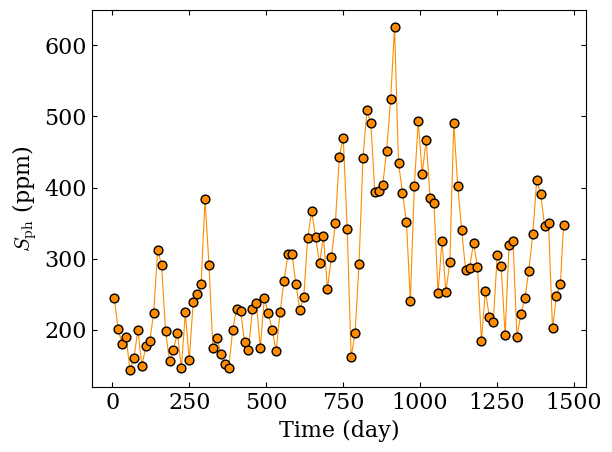

In [6]:
fig, ax = plt.subplots (1, 1)

ax.plot (t_sph, sph, color='darkorange', zorder=-1)
ax.scatter (t_sph, sph, color='darkorange', edgecolor='black',
            marker='o', s=40)

ax.set_xlabel ('Time (day)')
ax.set_ylabel (r'$S_\mathrm{ph}$ (ppm)')

fig.tight_layout ()

plt.savefig ('figures/kic3733735_sph_timeseries.png', dpi=300)

## Computing the ACF and GLS of the ACF time series

Now that we have our $S_\mathrm{ph}$ time series, let's compute its autocorrelation function and analyse it to extract periodicities above $P_\mathrm{thresh}$.

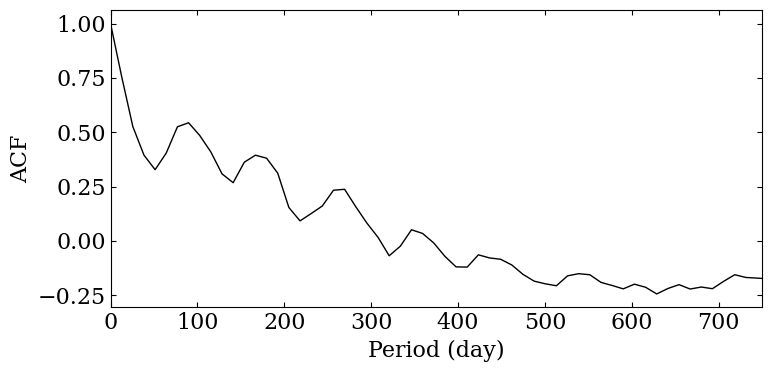

In [7]:
dt_sph = np.median (np.diff (t_sph))
p_acf_sph, acf_sph = sp.compute_acf (sph - np.mean (sph), dt_sph, normalise=True,
                                        use_scipy_correlate=True, smooth=False)
_, _, _, _, pmods_sph_acf, hacf, gacf = sp.find_period_acf (p_acf_sph, acf_sph, pcutoff=pcutoff)
fig = sp.plot_acf (p_acf_sph, acf_sph, prot=pmods_sph_acf, 
                      xlim=(0,750), filename='figures/kic3733735_sph_acf.png')

In [8]:
pmods_sph_acf, hacf, gacf

(array([], dtype=float64), array([], dtype=float64), array([], dtype=float64))

The second step is to compute the Lomb-Scargle periodogram of our $S_\mathrm{ph}$ time series. 

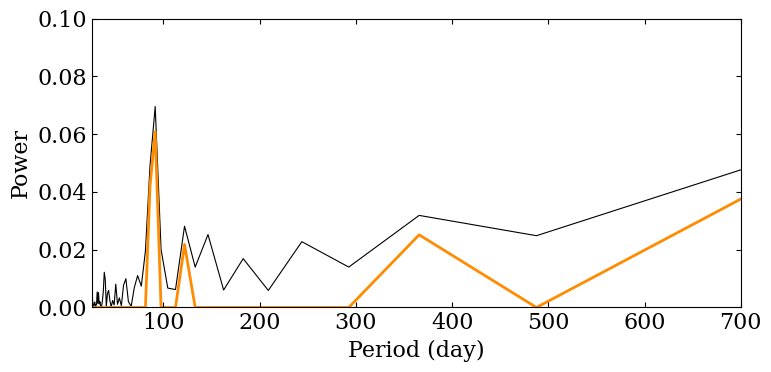

In [9]:
p_ps, ls, ps_object = sp.compute_lomb_scargle_sph (t_sph, sph)
(pmods_sph_fourier, e_p, 
 E_p, _, param, h_ps) = sp.compute_prot_err_gaussian_fit_chi2_distribution (p_ps[p_ps<pcutoff], ls[p_ps<pcutoff], 
                                                                            n_profile=5, threshold=0.1, verbose=False)
fig = sp.plot_ls (p_ps, ls, filename='figures/kic3733735_sph_fourier.png', 
                     logscale=False, param_profile=param,
                     ylim=(0, 0.1),
                     xlim=(2*dt_sph, 700))

## Building the $S_\mathrm{ph}$ intermediate data products

We build here the intermediate data products related to the $S_\mathrm{ph}$ analysis.

In [10]:
IDP_SAS_LONGTERM_MODULATION_SPH_FOURIER = sp.prepare_idp_fourier (param, h_ps, ls.size,
                                                             pcutoff=pcutoff, pthresh=None,
                                                             pfacutoff=1)
IDP_SAS_LONGTERM_MODULATION_SPH_TIMESERIES = np.c_[pmods_sph_acf, 
                                           np.full (pmods_sph_acf.size, -1), 
                                           np.full (pmods_sph_acf.size, -1),
                                           hacf, gacf, 
                                           np.arange (pmods_sph_acf.size)+1]

In [11]:
pd.DataFrame (data=IDP_SAS_LONGTERM_MODULATION_SPH_FOURIER)

,0,1,2,3,4
0,91.398640,0.091275,0.091458,0.069541,0.932822
1,731.156715,0.730139,0.731601,0.050999,0.950279
2,86.019303,0.085901,0.086072,0.049120,0.952067
3,365.549959,0.365012,0.365743,0.031863,0.968640
4,121.847440,0.121666,0.121910,0.028122,0.972269


In [12]:
pd.DataFrame (data=IDP_SAS_LONGTERM_MODULATION_SPH_TIMESERIES)

,0,1,2,3,4,5


## Comparing the long term modulations

Finally, we complete our set with mock (and arbitrary) data to illustrate how long term modulations from different IDP should be compared.

In [13]:
IDP_SAS_LONGTERM_MODULATION_FOURIER = np.array ([[90, 3, 3, 1, 1e-16],
                                                  [130, 5, 5, 1, 1e-16]])
IDP_SAS_LONGTERM_MODULATION_TIMESERIES = np.array ([[91, -1, -1, .3, .5, 1],
                                                    [132, -1, -1, .3, .4, 1],
                                                    [180, -1, -1, .3, .6, 2]])

In [14]:
DP4_SAS_LONGTERM_MODULATION = sp.build_long_term_modulation (
                                IDP_SAS_LONGTERM_MODULATION_FOURIER, 
                                IDP_SAS_LONGTERM_MODULATION_TIMESERIES,
                                IDP_SAS_LONGTERM_MODULATION_SPH_FOURIER, 
                                IDP_SAS_LONGTERM_MODULATION_SPH_TIMESERIES,
                                h_acf_min=0.2, g_acf_min=0.5
                                )

In [15]:
DP4_SAS_LONGTERM_MODULATION

array([[ 9.00000000e+01,  3.00000000e+00,  3.00000000e+00,
         9.10000000e+01, -1.00000000e+00, -1.00000000e+00,
         9.13986397e+01,  9.12749868e-02,  9.14576547e-02,
        -1.00000000e+00, -1.00000000e+00, -1.00000000e+00]])

In [16]:
pd.DataFrame (data=DP4_SAS_LONGTERM_MODULATION)

,0,1,2,3,4,5,6,7,8,9,10,11
0,90.0,3.0,3.0,91.0,-1.0,-1.0,91.39864,0.091275,0.091458,-1.0,-1.0,-1.0
